In [1]:
# Logger
import logging
logging.basicConfig(level=logging.WARN)

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS ACSM module
from bacs.agents.bacs import BACS, Configuration
from bacs.agents.bacs.utils.GymMazeWrapper import _maze_metrics, parse_metrics_to_df, plot_performance

# Load environments
import gym
import my_mazes

## Agent - BACS

### Common parameters

In [2]:
CLASSIFIER_LENGTH = 8
NUMBER_OF_POSSIBLE_ACTIONS = 8

MAZE = "Maze10-v0"

NUMBER_OF_EXPLORE_TRIALS = 1000
DO_ACTION_PLANNING_EXPLORE = False
DO_GA_EXPLORE = False
DO_SUBSUMPTION_EXPLORE = True
BETA_EXPLORE = 0.05
EPSILON = 0.8

NUMBER_OF_EXPLOIT_TRIALS = 500
DO_ACTION_PLANNING_EXPLOIT = False
DO_SUBSUMPTION_EXPLOIT = True
BETA_EXPLOIT = 0.05

LENGTH_OF_BEHAVIORAL_SEQUENCES = 1

### Environment - Maze

In [3]:
# Initialize environment
maze = gym.make(MAZE)
# Reset it, by putting an agent into random position
situation = maze.reset()
# Render the state in ASCII
maze.render()


■ ■ ■ ■ ■ ■ ■ ■ ■
■ A □ □ □ □ □ □ ■
■ □ ■ □ ■ □ ■ □ ■
■ □ ■ □ ■ □ ■ □ ■
■ □ ■ $ ■ □ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■ ■


### Training of BACS - Exploration

In [4]:
%%time

cfg_explore = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=DO_GA_EXPLORE,
    do_subsumption=DO_SUBSUMPTION_EXPLORE,
    do_action_planning=DO_ACTION_PLANNING_EXPLORE,
    action_planning_frequency=50,
    beta=BETA_EXPLORE,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=EPSILON,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=LENGTH_OF_BEHAVIORAL_SEQUENCES
)

agent_explore = BACS(cfg_explore)
population_explore, metrics_explore = agent_explore.explore(maze, NUMBER_OF_EXPLORE_TRIALS)

CPU times: user 56.7 s, sys: 10.3 ms, total: 56.7 s
Wall time: 56.7 s


In [5]:
population_explore_to_display = [cl for cl in population_explore if cl.does_anticipate_change()]
for cl in population_explore_to_display:
    print(cl)
    #print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.talp, cl.exp, cl.mark))
    print("\n")

00110110 7 None None 11001001         (empty)               q: 1.0   r: 309.6  ir: 0.0    f: 309.6  exp: 424 tga: 4     talp: 53827 tav: 1.58e+02 num: 1


###010## 2 None None ###101##         (11001001)            q: 0.427 r: 317.6  ir: 0.0    f: 135.6  exp: 516 tga: 11    talp: 54089 tav: 1.64e+02 num: 1


110#0#01 4 None None 001###10         (empty)               q: 1.0   r: 313.8  ir: 0.0    f: 313.8  exp: 515 tga: 13    talp: 54070 tav: 1.11e+02 num: 1


#0##0##0 4 None None #1##9##1         (00110110)            q: 0.337 r: 412.8  ir: 0.0    f: 139.0  exp: 1398 tga: 15    talp: 54170 tav: 51.1   num: 1


####9### 4 None None ####1###         (empty)               q: 1.0   r: 1e+03  ir: 1e+03  f: 1e+03  exp: 745 tga: 19    talp: 54206 tav: 1.07e+02 num: 1


01##0#11 0 None None #0#####0         (01110111)            q: 0.623 r: 302.9  ir: 0.0    f: 188.7  exp: 2494 tga: 131   talp: 54193 tav: 25.0   num: 1


#0#####0 4 None None #1#####1         (00110110)            q: 0.675 r: 

### Exploitation of BACS

In [6]:
%%time

cfg_exploit = Configuration(
    classifier_length=CLASSIFIER_LENGTH,
    number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
    user_metrics_collector_fcn=_maze_metrics,
    metrics_trial_frequency=1,
    do_ga=False,
    do_subsumption=DO_SUBSUMPTION_EXPLOIT,
    do_action_planning=DO_ACTION_PLANNING_EXPLOIT,
    action_planning_frequency=50,
    beta=BETA_EXPLOIT,
    gamma=0.95,
    theta_i=0.1,
    theta_r=0.9,
    epsilon=0.0,
    u_max=CLASSIFIER_LENGTH,
    theta_exp=20,
    theta_ga=100,
    theta_as=20,
    mu=0.3,
    chi=0.8,
    bs_max=1
)

agent_exploit = BACS(cfg_exploit, population_explore)
agent_exploit.clean_population(does_anticipate_change=True)
population_exploit, metrics_exploit = agent_exploit.exploit(maze, NUMBER_OF_EXPLOIT_TRIALS)

CPU times: user 7.45 s, sys: 0 ns, total: 7.45 s
Wall time: 7.45 s


### Performance

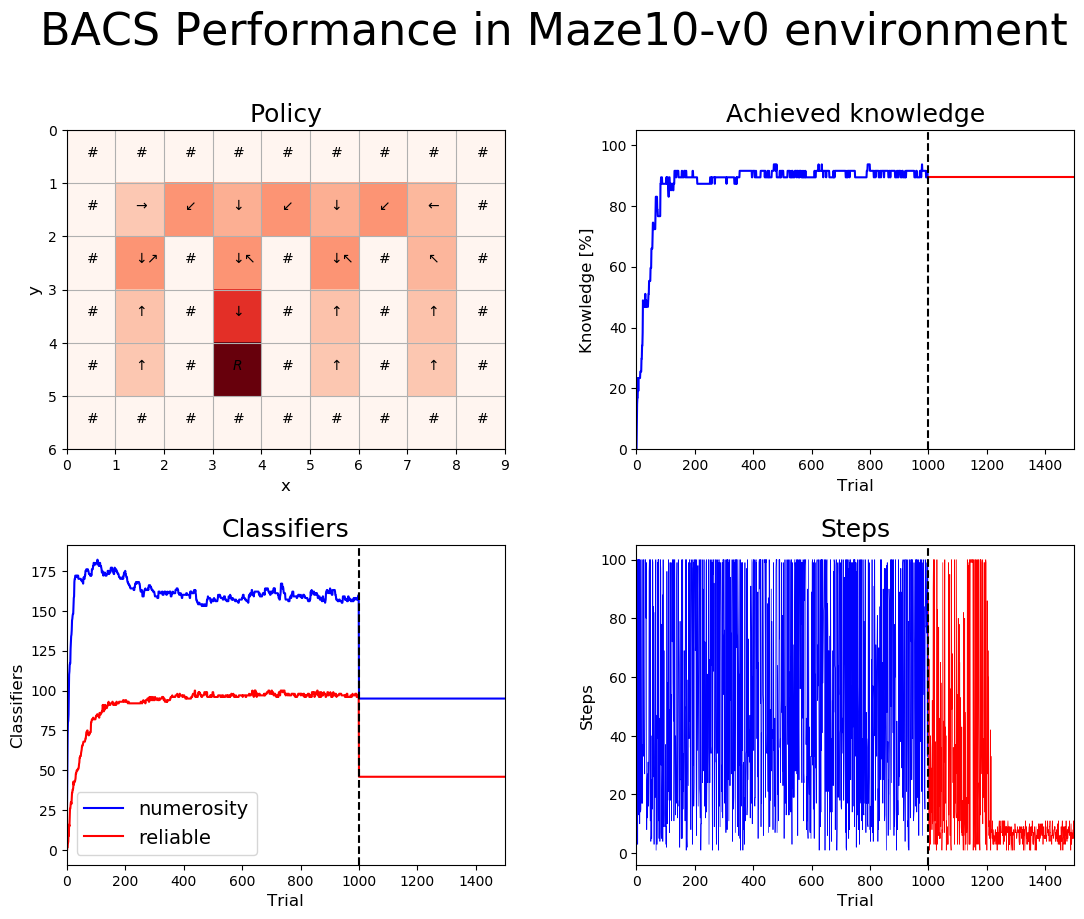

In [7]:
metrics_df = parse_metrics_to_df(metrics_explore, metrics_exploit)
plot_performance(agent_exploit, maze, metrics_df, cfg_exploit, MAZE)

In [8]:
avg_step_explore = 0
for trial in metrics_explore:
    avg_step_explore += trial['steps_in_trial']
avg_step_explore /= NUMBER_OF_EXPLORE_TRIALS

print("Average number of steps to solve the maze is ",avg_step_explore,
      " for a total of ", NUMBER_OF_EXPLORE_TRIALS, " trials in EXPLORATION")

avg_step_exploit = 0
for trial in metrics_exploit:
    avg_step_exploit += trial['steps_in_trial']
avg_step_exploit /= NUMBER_OF_EXPLOIT_TRIALS

print("Average number of steps to solve the maze is ",avg_step_exploit,
      " for a total of ", NUMBER_OF_EXPLOIT_TRIALS, " trials in EXPLOITATION")

Average number of steps to solve the maze is  54.207  for a total of  1000  trials in EXPLORATION
Average number of steps to solve the maze is  20.842  for a total of  500  trials in EXPLOITATION


In [9]:
population_exploit.sort(key=lambda cl: -cl.fitness)
population_exploit_to_display = [cl for cl in population_exploit]
for cl in population_exploit_to_display:
    print(cl)
    #print("{!r} \t {!r} \t {!r} \t {:.3f} \t {:.3f} \t {:.1f} \t {!r} \t {!r}".format(cl.condition, cl.action, cl.effect, cl.fitness, cl.q, cl.num, cl.exp, cl.mark))
    print("\n")

####9### 4 None None ####1###         (empty)               q: 1.0   r: 1e+03  ir: 1e+03  f: 1e+03  exp: 745 tga: 19    talp: 54206 tav: 1.07e+02 num: 1


11001001 5 [4] [('0', '0', '1', '1', '0', '1', '1', '0')] 0#11011#         (11001001)            q: 0.714 r: 776.0  ir: 0.0    f: 554.4  exp: 356 tga: 1336  talp: 54192 tav: 1.83e+02 num: 1


00110110 7 None None 11001001         (empty)               q: 1.0   r: 542.4  ir: 0.0    f: 542.4  exp: 424 tga: 4     talp: 53827 tav: 1.58e+02 num: 1


11010101 4 [4] [('0', '0', '1', '1', '0', '1', '1', '0')] 0#1#9#1#         (11010101)            q: 0.623 r: 692.0  ir: 0.0    f: 431.2  exp: 1253 tga: 663   talp: 54198 tav: 43.4   num: 1


11010101 4 [4] [('0', '0', '1', '1', '0', '1', '1', '0')] 0#1###1#         (11010101)            q: 0.578 r: 692.0  ir: 0.0    f: 399.9  exp: 1247 tga: 3561  talp: 54198 tav: 43.4   num: 1


00110111 1 [2] [('1', '1', '0', '0', '1', '0', '0', '1')] 110###0#         (empty)               q: 1.0   r: 398.2  